<a href="https://colab.research.google.com/github/ceroytres/website_notebooks/blob/master/EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.special import softmax

In [2]:
np.random.seed(0)

N = 15
pi = .5
mu_star = 2
x = [np.random.randn() + mu_star if np.random.rand() < pi else 
     np.random.randn() - mu_star \
     for _ in range(N)]
x = np.array(x)

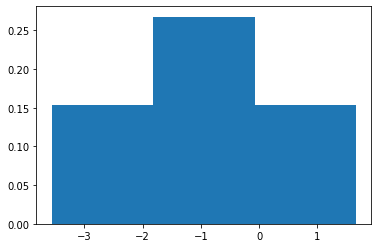

In [3]:
plt.figure()
plt.hist(x, density = True, bins = int(np.sqrt(N)))
plt.show()

In [4]:
def compute_log_marginal(x: np.ndarray, mu: float) -> float:
  log_marginal = np.log(pi * norm.pdf(x,loc=mu) \
                        + (1-pi) * norm.pdf(x,loc=-mu))
  return np.mean(log_marginal)


def ELBO(mu: float, mu_old: float, x: np.ndarray) -> float:
  eps = 1e-32
  gamma = np.stack([norm.pdf(x, loc=mu_old) * pi,
                    (1-pi) * norm.pdf(x, loc=-mu_old)], axis = 1)
  gamma += eps
  gamma = gamma/np.sum(gamma, axis = 1, keepdims=True)

  entropy = -np.mean(np.sum(gamma*np.log(gamma + eps), axis = 1))

  Q = gamma[:,0] * (np.log(pi) + np.log(norm.pdf(x,loc=mu)+eps)) + \
      gamma[:,1] * (np.log(1-pi) + np.log(norm.pdf(x, loc=-mu)+eps))
  
  Q = np.mean(Q)
  ELBO = Q + entropy
  return ELBO


def em_step(x: np.ndarray, mu_old: float) -> float:
  eps = 1e-32
  gamma = np.stack([norm.pdf(x, loc=mu_old) * pi,
                    (1-pi) * norm.pdf(x, loc=-mu_old)], axis = 1)
  gamma += eps
  gamma = gamma/np.sum(gamma, axis = 1, keepdims=True)
  new_mu = np.mean(x * (gamma[:,0]-gamma[:,1]))
  return new_mu




In [5]:
mu_old = .5

mus = np.linspace(-5,5,1000)
log_marginal = [compute_log_marginal(x, m) for m in mus]
elbo = [ELBO(m, mu_old, x) for m in mus]

old_marignal = compute_log_marginal(x, mu_old)
old_elbo = ELBO(mu_old,mu_old,x)

mu_new = em_step(x, mu_old)
new_elbo = ELBO(mu_new, mu_old, x)
print(f"Difference between log marginal and lower bound at mu_old {old_elbo - old_marignal}")
print(f"New mu {mu_new}")

Difference between log marginal and lower bound at mu_old 4.440892098500626e-16
New mu 1.055001292401026


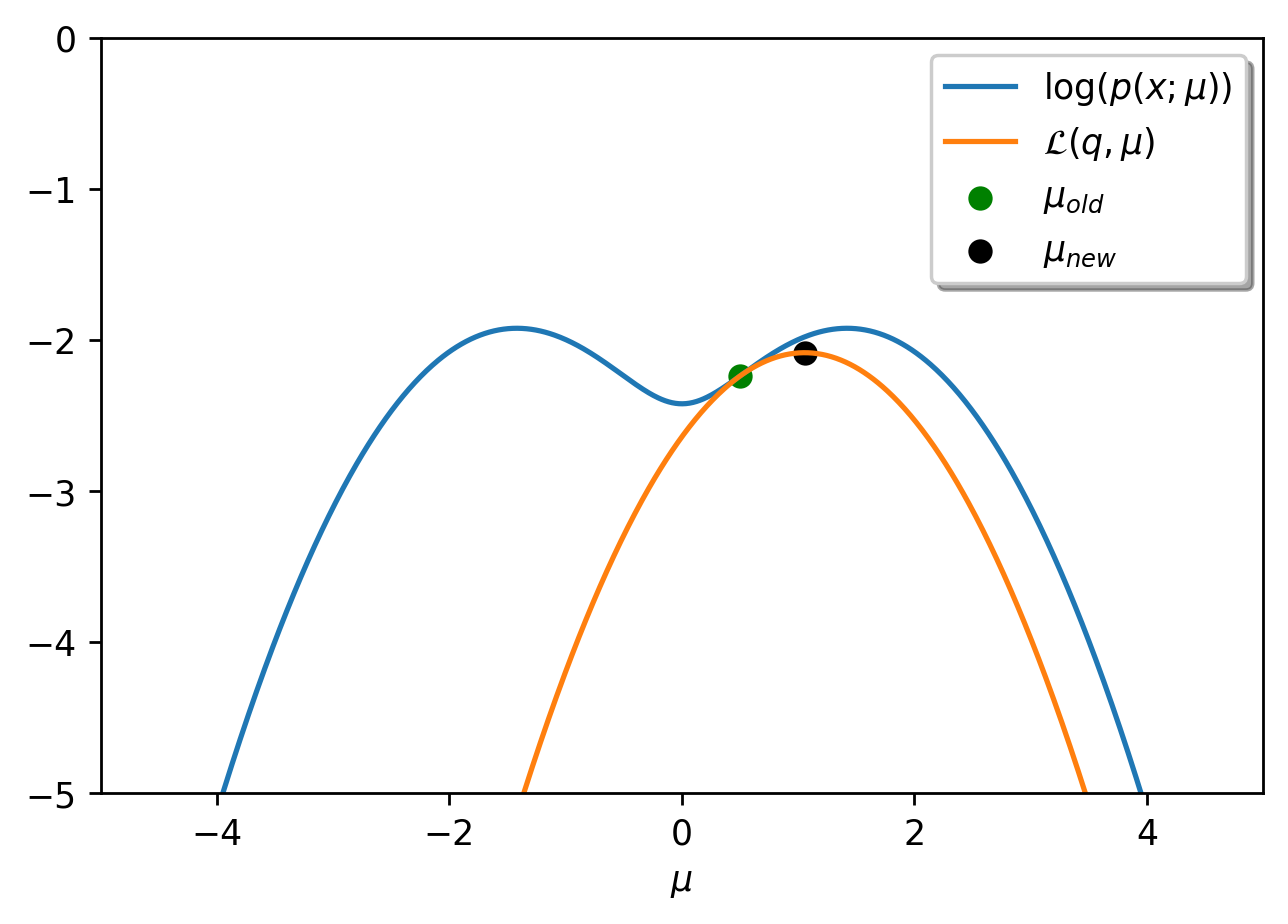

In [9]:
plt.figure(dpi=250)
plt.plot(mus, log_marginal, label=r"$\log(p(x;\mu))$")
plt.plot(mus, elbo, label = r"$\mathcal{L}(q,\mu)$")
plt.scatter([mu_old], [old_elbo], c="g",label = r"$\mu_{old}$")
plt.scatter([mu_new], [new_elbo], c="k",label = r"$\mu_{new}$")
plt.xlabel(r"$\mu$")
plt.legend(fancybox=True, shadow=True)
plt.xlim([-5,5])
plt.ylim([-5,0])
plt.show()